# Final report, v-AMOS Team

## Introduction
The following notebook is intended as a report for the final project of the course "Data Science" (Prof. Peroni), consisting of a Python query processor for graph and relational databases. It was developed by the team "v-AMOS", composed by four students of the MA "Digital Humanities and Digital Humanities" at University of Bologna: [Amelia Lamargese](mailto:amelia.lamargese@studio.unibo.it), [Olga Pagnotta](mailto:olga.pagnotta@studio.unibo.it), [Manuele Veggi](mailto:manuele.veggi@studio.unibo.it) e [Sara Vellone](mailto:sara.vellone@studio.unibo.it).

The specific guidelines of the project are available at the following [page](https://github.com/comp-data/2021-2022/tree/main/docs/project).

![workflow](file:///var/folders/tj/5t1fgpzs7yq13p2pk4y81j1c0000gn/T/TemporaryItems/NSIRD_screencaptureui_fsZoCJ/Schermata%202022-05-06%20alle%2013.09.09.png)

## Data Model

The databases contain information about different academic publications. The entirety of the pieces of information provided can be organized within a data model and graphically visualized through UML.

![classes data model](imgJupiNB/umlClasses.png)

One of the first tasks hence concerned the translation of the model into a proper Python code. Following the syntax of classes declaration, we started defining properties and methods of *IdentifiableEntity*, as all the other classes are its subclasses. 

In [17]:
class IdentifiableEntity:
    def __init__(self, identifier):
        self.identifier = identifier

    def getIds(self):
        return list(self.identifier)

Later on, we proceeded with the subclasses *Person* and *Organization*:

In [18]:
class Person(IdentifiableEntity):
    def __init__(self, identifier, givenName, familyName):
        super().__init__(identifier)
        self.givenName = givenName
        self.familyName = familyName

    def getGivenName(self):
        return self.givenName

    def getFamilyName(self):
        return self.familyName


class Organization(IdentifiableEntity):
    def __init__(self, identifier, name):
        super().__init__(identifier)
        self.name = name

    def getName(self):
        return self.name

We also defined *Publication* and its subclasses (*JournalArticle*, *BookChapter*, *ProceedingsPaper*).

In [19]:
class Publication(IdentifiableEntity):
    def __init__(self, identifier, publicationYear, title, cited, authors, publicationVenue):
        super().__init__(identifier)
        self.publicationYear = publicationYear
        self.title = title
        self.cited = cited
        self.authors = authors
        self.publicationVenue = publicationVenue

    def getPublicationYear(self):
        return self.publicationYear

    def getTitle(self):
        return self.title

    def getCitedPublications(self):
        return self.cited 

    def getPublicationVenue(self):
        return self.publicationVenue

    def getAuthors(self):
        return self.authors  


class JournalArticle(Publication):
    def __init__(self, identifier, publicationYear, title, cited, authors, publicationVenue, issue, volume):
        super().__init__(identifier, publicationYear, title, cited, authors, publicationVenue)
        self.issue = issue
        self.volume = volume

    def getIssue(self):
        return self.issue

    def getVolume(self):
        return self.volume


class BookChapter(Publication):
    def __init__(self, identifier, publicationYear, title, cited, authors, publicationVenue, chapterNumber):
        super().__init__(identifier, publicationYear, title, cited, authors, publicationVenue)
        self.chapterNumber = chapterNumber

    def getChapterNumber(self):
        return self.chapterNumber


class ProceedingsPaper(Publication):
    pass

Lastly, we declared *Venue* and the subclasses *Journal*, *Book* and *Proceedings*.

In [20]:
class Venue(IdentifiableEntity):
    def __init__(self, identifier, title, publisher):
        super().__init__(identifier)
        self.title = title
        self.publisher = publisher

    def getTitle(self):
        return self.title

    def getPublisher(self):
        return self.publisher


class Journal(Venue):
    pass


class Book(Venue):
    pass


class Proceedings(Venue):
    def __init__(self, identifier, title, publisher, event):
        super().__init__(identifier, title, publisher)
        self.event = event

    def getEvent(self):
        return self.event

## Additional classes

The classes defining the functioning of the query processor have been described in the following UML model:

![imgJupiNB/umlQueryPro.png](imgJupiNB/umlQueryPro.png)

To complete the translation in Python, the workload was split into two halves: firstly, the creation and the query software for the relational database was created, then the same functionalities were adapted to the graph database. 

### Relational database

The relational database is handled by the the class **RelationalProcessor** and its two subclasses, *RelationalDataProcessor* and *RelationalProcessor*. The former is defined through file path (below mentioned as *dbPath*) and by the two methods *getdbPath* and *setdbPath* and has been defined as follows:

In [ ]:
class RelationalProcessor:
    def __init__(self, dbPath):
        self.dbPath = dbPath

    def getDbPath(self):  
        return self.dbPath

    def setDbPath(self, path):
        if path != '': 
            self.dbPath = path
            return True 
        else:
            return False

The subclass **RelationalDataProcessor** is encharged of the creation of the database starting from the two input files. Given that these two inputs can be either in CSV or JSON format, the method *uploadData* needs to be modeled in two halves, one of each focused on the treatment of a specific file format. These first lines commit to *dbPath* the dataframe *General*, populated with the entries of CSV file.

On the contrary, the JSON file has a very complex and nested structure. It is hence difficult to visualize simultaneously all the information in a sole table. The four main keys (`"authors"`, `"venues_id"`, `"references"` and `"publishers"`) allow to create four distinct dataframes and each of them has been populated with an *ad hoc* algorithm, able to take into account the peculiarities of the considered dataset. 

### Graph Database

For what concerns the Graph Database, we have populated a Triplestore Database, in order to store and retrieve RDF triples. We have used Blazegraph, a high performance graph database, suitable for RDF triples. 

The file named **triplestoreProcessorClasses.py** contains all the information regarding this database.

The first step for the creation of the data base has been the definition of the variables, which were then used for the creation of the triples: subject, predicate, object.

In [ ]:
base_url = "https://github.com/olgagolgan/v-AMOS"

As from the code above, the first variable defined is the base URL, which has been used, in the next steps, to create the common basis for the subject of the triples, enriched, in the various triples, by a significant ID regarding the specific info dealt in the triple, as in the following example, where the "local_id" corresponds to the DOI of the specific publication taken into consideration:

In [ ]:
 for idx, row in table.iterrows():
    local_id = row["id"]
    subj = URIRef(base_url + "/" + local_id)

The next variables being defined are the specific classes of the UML data model provided above: JournalArticle, BookChapter, Journal and Book. They have been associated to a meaninful URI taken from the schema.org ontology, describing their features. For example, the JournalArticle has been defined by means of the schema.org property "ScholarlyArticle", being it the nearest to the articles in our dataset:

In [ ]:
JournalArticle = URIRef("https://schema.org/ScholarlyArticle")

For what concerns the attributes of the various classes, some properties taken from schema.org have been chosen, in order to be at the same time the most specific and uniquely identifiable for every variable. For example, there are present four different kinds of ID: doi, identifier, orcid, venueID. For each of them, a meaningful property has been chosen. For the doi, the property "https://schema.org/productID" has been chosen, for the characteristics desrcibed in the schema.org ontology, thus identifying a product, as a publication. For the generic identifier attribute, we decided to use the schema.org "https://schema.org/identifier" property, as associate it, in the triples, to the publisher id. For the orcid, the property "https://schema.org/creator" has been chosen and lastly, for the venueID we have used the property "https://schema.org/VirtualLocation", being a Venue, somehow, a virtual/figurative location for the publication taken into consideration.

In [ ]:
doi = URIRef("https://schema.org/productID")
identifier = URIRef("https://schema.org/identifier")
orcid = URIRef("https://schema.org/creator")
venueID = URIRef("https://schema.org/VirtualLocation")

Other variables, such as issue, volume, event, etc., has been associated with other schema.org properties.

The next step has been the instanciation of the class **TriplestoreProcessor**, which allows to set and retrieve the endpointUri corresponding to the blazegraph endpoint containing our database. For avoiding any kind of error, we decided to set as endpointUri, in the execution of the queries, the local endpoint "http://127.0.0.1:9999/blazegraph", always accessible from every machine.

Then, we defined the **TriplestoreProcessor** subclass named **TriplestoreDataProcessor**, responsible first of all for the creation of the RDF triples, and secondly for the upload of the data into the database. To start with, in the method "uploadData" a graph is created with the rdflib method Graph() and a connection is stablished with the endpointUri, using the SPARQLUpdateStore() method:

In [ ]:
my_graph = Graph()
store = SPARQLUpdateStore()
store.open((self.endpointUri, self.endpointUri))

Then, the different extensions of the file being uploaded are handled checking the last part of the Path Name:

In [ ]:
 if path.endswith(".csv"):
    table = read_csv(path, keep_default_na=False)
# code goes on in between 
 elif path.endswith(".json"):
    jsonfile = open(path, mode="r", encoding="utf-8")

Being the file uploaded either a csv or a json, different triples, based on the internal structure of the files themselves, are created and added to the graph. The structure of the csv file is more linear: the subject is created, as shown above, with the addition of a local_id, corresponding to the doi:

In [ ]:
for idx, row in table.iterrows():
    local_id = row["id"]
    subj = URIRef(base_url + "/" + local_id)

An example of a triple, for the description of the title, is the following:

In [ ]:
my_graph.add((subj, title, Literal(row["title"])))

For what concerns the json file, the structure is slighlty different and more complex. Thus the local_id changes regarding the different sections of the file, chosing the most important identifier for that purpose: 

1. for the object "authors", the local_id corresponds to the orcid (which will be then used to connect the json file, containing info about the given name and family name of the author, to the info contained in the csv file, regarding the publication authored by the person having name and surname the formers)

In [ ]:
subj = URIRef(base_url + "/" + author["orcid"])

2. for the object "venues_id", the local_id corresponds to the actual id of the venue taken into consideration, being it a doi and connecting thus the json file to the csv

In [ ]:
subj = URIRef(base_url + "/" + venues_id)

3. for the object "references", containing info about citations of a certain publication, the local_id corresponds to the reference and is also a doi

In [ ]:
subj = URIRef(base_url + "/" + reference)

4. lastly, for the object publisher, containing additional information about the name of the publisher, enriching the content of the csv file, the local_id corresponds to the publisher id

In [ ]:
subj = URIRef(base_url + "/" + table["publishers"][publish]["id"])

The last step, now that the database has been populated, it to retrieve the required information from it, through the **TriplestoreProcessor** subclass **TriplestoreQueryProcessor**. SPARQL syntax has been used in order to formulate the queries for retrieving information from the database, using the python library sparql_dataframe in order to handle the queries directly inside python. Nested queries have been created in order to handle the different information required from the UML classes. For example, for retrieving all the information regarding a certain publication published in a specific year, the following SPARQL query has been formulated:

In [ ]:
   def getPublicationsPublishedInYear(self, year):
        qry = """
            PREFIX schema: <https://schema.org/>
            SELECT ?orcid ?given ?family ?title ?doi ?publication_venue ?publisher ?publication_year
            WHERE {
            {SELECT ?orcid ?title ?doi ?publication_venue ?publisher ?publication_year
            WHERE{
              ?s schema:creator ?orcid.
              ?s schema:title ?title.
              ?s schema:productID ?doi.
              ?s schema:publishedBy ?publisher.
              ?s schema:isPartOf ?publication_venue.
              ?s schema:datePublished ?publication_year.
              ?s schema:datePublished """ + str(year) + """ 
            }              
            }
             ?x schema:creator ?orcid.
             ?x schema:givenName ?given.
             ?x schema:familyName ?family
        }"""

        df_sparql = get(self.endpointUri, qry, True)
        return df_sparql


giving as output the following dataframe, with infomation about the orcid, given name, family name of the author and the title, doi, publisher, publication venue and publication year (passed as input of the method) of the publication published in year 2020:

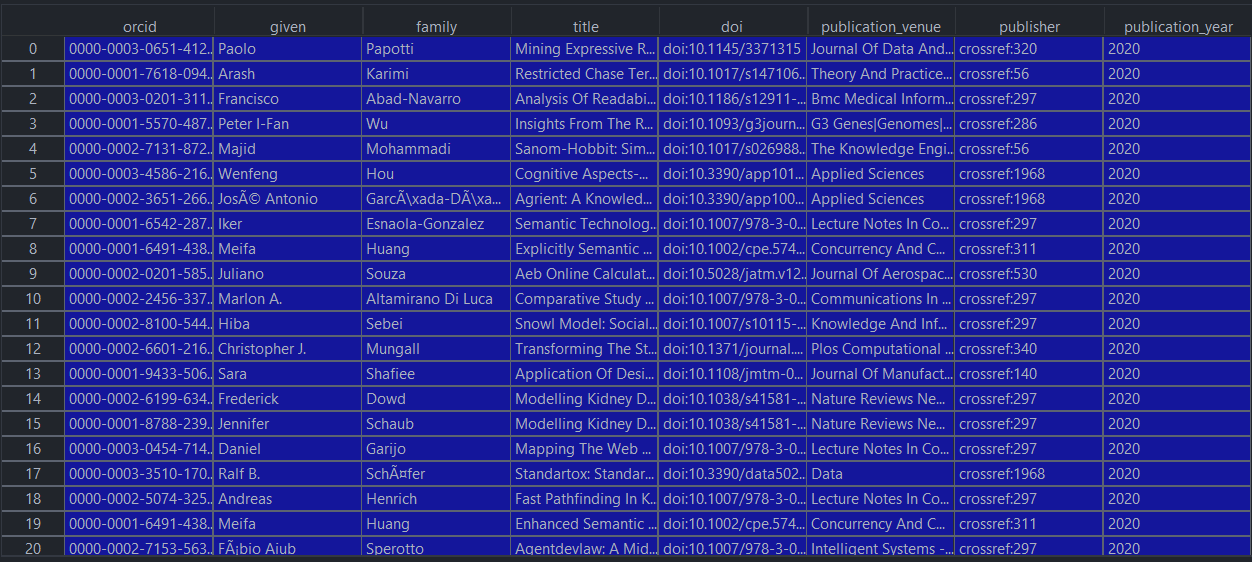

One problem has been found in the development of one specific query, getProceedingsByEvent(self, eventPartialName), because in the dataset provided no events were present. For this reason a fake event has been added to the dataset, in order to test the following query, in which a Filter expression with regex has been used in order to handle the upper/lowercase of the name and the incompleteness of it:

In [ ]:
  def getProceedingsByEvent(self, eventPartialName):
        qry = """
         PREFIX schema:<https://schema.org/>

          SELECT ?publication_venue ?venue_id ?publisher
          WHERE {
              ?s schema:title ?publication_venue.
              ?s schema:VirtualLocation ?venue_id.
              ?s schema:publishedBy ?publisher.
              ?s schema:Event ?event.
              FILTER (REGEX(?event,'""" + str(eventPartialName) + """', "i"))
          }
         """
        df_sparql = get(self.endpointUri, qry, True)
        return df_sparql

One method has been added to the ones required in the UML datamodel, getCitedPublications(self, publicationId), in order to retrieve all the information about the publication cited by another publication, thus the publication cited, the orcid, given name, family name of their authors, the title, publication venue, publisher and publication year of each of them:

In [ ]:
 def getCitedPublications(self, publicationId):
        qry = """
            PREFIX schema: <https://schema.org/>
            SELECT ?cite ?orcid ?given ?family ?title ?publication_venue ?publisher ?publication_year
            WHERE{ 
              {SELECT ?title ?publication_venue ?publication_year ?publisher ?orcid ?cite
               WHERE{ 
                 {SELECT ?cite
                  WHERE{
                       ?y schema:citation ?cite.
                       ?y schema:productID '""" + str(publicationId) + """'
                     }
                 }
                     ?x schema:citation ?cite.
                     ?x schema:title ?title.
                     ?x schema:isPartOf ?publication_venue.
                     ?x schema:datePublished ?publication_year.
                     ?x schema:publishedBy ?publisher.
                     ?x schema:creator ?orcid
                }}
        
                ?x schema:creator ?orcid.
                ?x schema:givenName ?given.
                ?x schema:familyName ?family
            }"""
        df_sparql = get(self.endpointUri, qry, True)
        return df_sparql